# Natural Language Processing with Disaster Tweets: Assessing predictive performance of the baseline LSTM, GRU and their hybrid counterpart

**Jay Manvirk (Ivan Loginov)**<br/>
University of Colorado, Boulder<br/>
jay.manvirk@gmail.com

# Table of Contents

1. [Abstract](#chapter_1)
2. [Introduction](#chapter_2)
3. [Libraries and raw data](#chapter_3)
    - 3.1 [Libraries](#chapter_3_1)
    - 3.2 [Raw data](#chapter_3_2)
4. [Exploratory data analysis](#chapter_4)
    - 4.1 [Short datasets summary](#chapter_4_1)
    - 4.2 [Number of records per class](#chapter_4_2)
    - 4.3 [Word frequencies per class](#chapter_4_3)
5. [Data preprocessing](#chapter_5)
    - 5.1 [Upsampling](#chapter_5_1)
    - 5.2 [Text Cleaning](#chapter_5_2)
    - 5.3 [Text Tokenization](#chapter_5_3)
    - 5.4 [Word2Vec](#chapter_5_4)
    - 5.5 [Train-test split](#chapter_5_5)
6. [Model architectures](#chapter_6)
    - 6.1 [LSTM](#chapter_6_1)
    - 6.2 [GRU](#chapter_6_2)
    - 6.3 [Hybrid](#chapter_6_3)
7. [Model results](#chapter_7)
8. [Submission results](#chapter_8)
9. [Conclusion](#chapter_9)
10. [References](#chapter_10)

# 1. Abstract <a class="anchor" id="chapter_1"></a>

TODO

# 2. Introduction <a class="anchor" id="chapter_2"></a>

TODO

# 3. Libraries and data <a class="anchor" id="chapter_3"></a>

## 3.1 Libraries <a class="anchor" id="chapter_3_1"></a>

In [ ]:
# basics
import os
import time
import numpy as np

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import re
import spacy
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from concurrent.futures import ProcessPoolExecutor
from sklearn.model_selection import train_test_split

# Model architectures
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


## 3.2 Raw Data <a class="anchor" id="chapter_3_2"></a>

In [ ]:
# Print list of files in folder
files = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        files.append(os.path.join(dirname, filename))
files

In [ ]:
# Set datasets
train_data = pd.read_csv(files[1])
test_data = pd.read_csv(files[2])
submit_data = pd.read_csv(files[0])

In [ ]:
# Cleaning
del files

# 4. Exploratory data analysis <a class="anchor" id="chapter_4"></a>

## 4.1 Short datasets summary <a class="anchor" id="chapter_4_1"></a>

Our dataset has some missing values in the keyword and location columns. If we remove these entries, we'll lose about 33% of the data. Since we're concentrating on Twitter texts, we can keep the null values and use all the available information.

In [10]:
def print_short_summary(name, data):
    """
    Print data head, shape and info.
    
    Args:
        name (str): name of dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2 Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()

In [11]:
print_short_summary('Train data', train_data)

Train data

1. Data head:
   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]

2 Data shape: (7613, 5)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [12]:
print_short_summary('Test data', test_data)

Test data

1. Data head:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

2 Data shape: (3263, 4)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [13]:
print_short_summary('Sample submission data', submit_data)

Sample submission data

1. Data head:
   id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0

2 Data shape: (3263, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


In [15]:
# Cleaning
del print_short_summary

## 4.2 Number of records per class <a class="anchor" id="chapter_4_2"></a>

The dataset shows an imbalance, with around 30% fewer disastrous tweets compared to non-disastrous ones. To fix this gap, we'll increase the number of disastrous tweets to match the non-disastrous ones. This should ensure our models won't overlook the minority class.

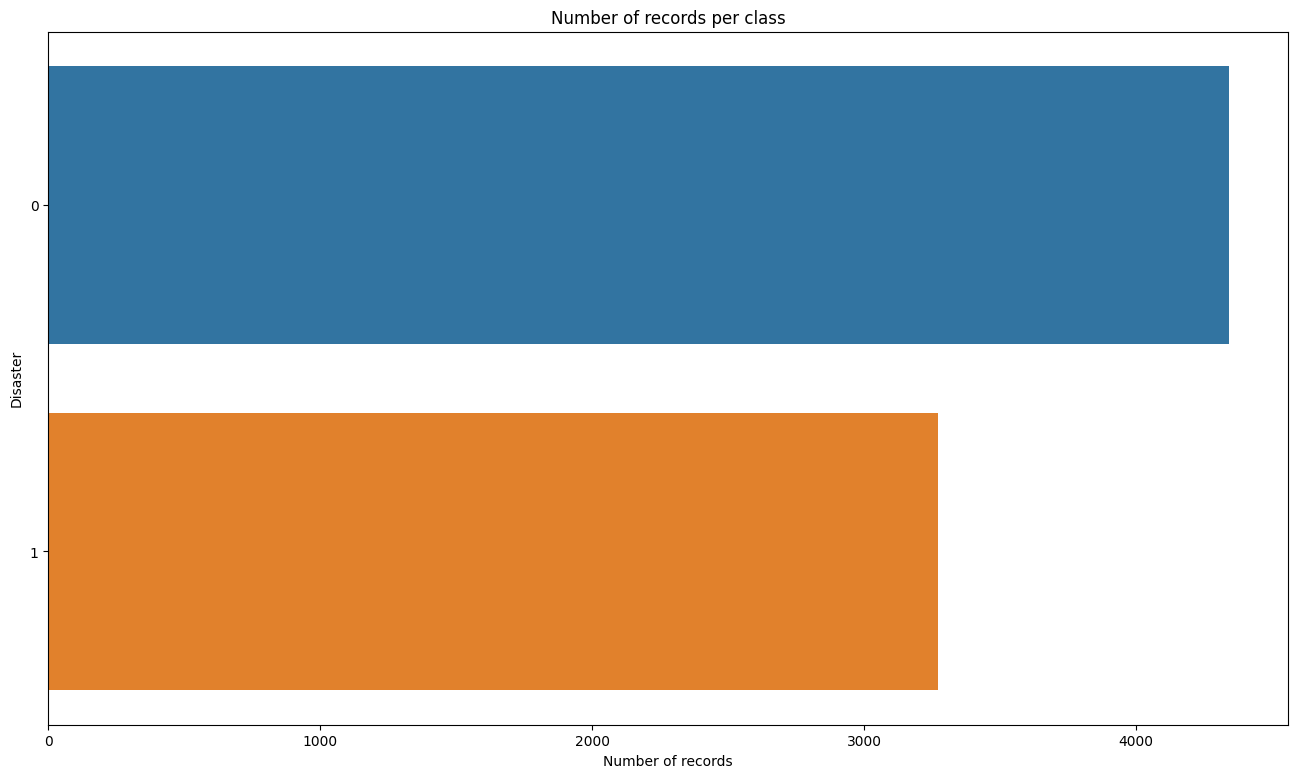

In [17]:
# Plot horizontal barplot of the number of records per class
plt.figure(figsize=(16, 9))
tmp = train_data['target'].value_counts()
sns.barplot(y=tmp.index.values, x=tmp.values, orient='h')
plt.xlabel('Number of records')
plt.ylabel('Disaster')
plt.title('Number of records per class')
plt.show()

In [18]:
# Cleaning
del tmp

## 4.3 Word frequencies per class <a class="anchor" id="chapter_4_3"></a>

There's a significant overlap in words used across both classes, which doesn't provide specific class-related information. To minimize this noise, we'll clean the data in the next section.

In [23]:
def plot_word_dist_class(labels, top_n_words = 10):
    """
    Plot charts with word frequencies per class.
    
    Args:
        labels: list of classes
        top_n_words (opt): how many top words to plot in one chart
    """
    n = len(labels)
    
    # Get default seaborn's palette to match colours with the previous chart
    default_palette = sns.color_palette("deep")
    
    # Initialize subplots with 1 row and n columns
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(16, 9))
    
    # Plot word count per author in the respective rows
    for i in range(n):
        col = i % n
        indexes = train_data['target'] == labels[i]
        w = train_data['text'][indexes].str.split(expand=True).unstack().value_counts()
        l = w[:top_n_words]/np.sum(w)*100
        axes[col].bar(l.index, l.values, color=default_palette[i])
        axes[col].set_title(labels[i])
        axes[col].set_xlabel('Words')
        axes[col].set_ylabel('Percentage of total word count (%)')

    plt.tight_layout()
    plt.show()

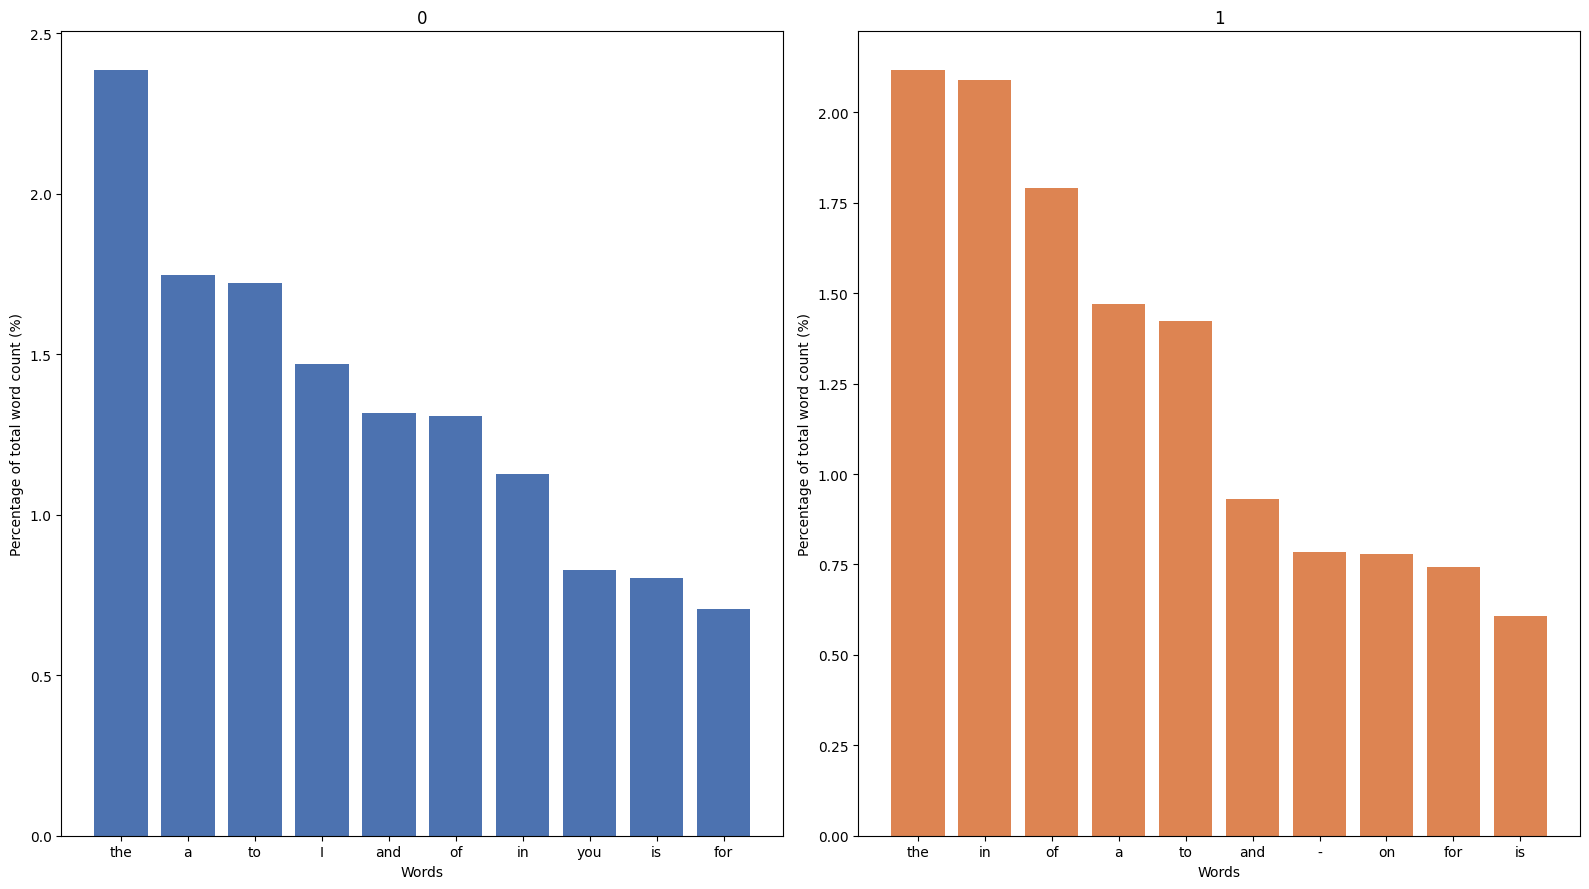

In [24]:
# Plot word frequencies by class
plot_word_dist_class([0,1])

In [25]:
# Cleaning
del plot_word_dist_class

# 5. Data preprocessing <a class="anchor" id="chapter_5"></a>

## 5.1 Upsampling <a class="anchor" id="chapter_5_1"></a>

This section focuses on balancing the class distribution in the training dataset by increasing the number of disastrous tweet samples through upsampling.

In [35]:
# Get maximum number of records (non-disastrous)
max_count = sum(train_data['target'] == 0)

# Upsample siastrous tweets to the max number of non-disastrous
balanced_data = []
for i in range(2):
    class_data = train_data[train_data['target'] == i]
    upsampled_data = class_data.sample(max_count
                                     , replace = True
                                     , random_state = 0)
    balanced_data.append(upsampled_data)

train_data_balanced = pd.concat(balanced_data)
train_data_balanced['target'].value_counts()

target
0    4342
1    4342
Name: count, dtype: int64

In [46]:
# Cleaning
del max_count, balanced_data, class_data, upsampled_data

## 5.2 Text cleaning <a class="anchor" id="chapter_5_2"></a>

In this step, we'll get rid of single letters and the most common stopwords identified during our EDA. By doing so, we can improve the model's accuracy in determining the class of each tweet.

In [72]:
# Load english lemmas
spacy_process = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Compile regex pattern
pattern = re.compile(r'\b([a-zA-Z])\b')

# Set english stopwords such as "the", "of", "and", "to" etc.
stop_words = set(stopwords.words('english'))

In [70]:
def get_processed_text(text):
    """
    Return lemmatized text without single letters and frequent stopwords.
    Everything is in the lower case register.
    
    Args:
        text (str): text of an article
    Returns:
        string: text of clean lemmas
    """
    # Convert to lowercase and remove digits, single letters
    text = pattern.sub('', text.lower())
    
    # Get lemma tokens
    lemmas = spacy_process(text)
    lemmas = [token.lemma_ for token in lemmas if token.text not in stop_words]
    
    return ' '.join(lemmas)

def get_clean_text(texts):
    """
    Return list of cleaned texts.
    Execution in parallel.
    
    Args:
        texts: numpy array of string elements
    Returns:
        list: list of cleaned lemmatized tokens
    """
    # Set up parallel tasks processing 
    with ProcessPoolExecutor() as executor:
        clean_texts = list(executor.map(get_processed_text, texts))
        
    return clean_texts

In [81]:
# Get cleaned train and test texts
train_clean_data = get_clean_text(train_data['text'].values)
test_clean_data = get_clean_text(test_data['text'].values)

In [ ]:
# Cleaning
del spacy_process, pattern, stop_words
del get_clean_text, get_processed_text

## 5.3 Text tokenization <a class="anchor" id="chapter_5_3"></a>

In this section we create a list of lists, where each inner list represents a sentence. The numbers in these lists are word indices from the original sentences. These numerical sequences are later going to be used for training in Word2Vec.

In [83]:
# Create and fit Tokenizer object
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_clean_data)
# Convert text to the list of word indexes in corpus
sequences = tokenizer.texts_to_sequences(train_clean_data)
# Get vocabulary size for embedding matrix
vocab_size = len(tokenizer.word_index) + 1

## 5.4 Word2Vec <a class="anchor" id="chapter_5_4"></a>

Word2Vec transforms tokens into high-dimensional vectors, making them suitable for deep learning models. It converts them into vector representations. By predicting, in our case, word indices based on neighboring indices, Word2Vec enhances the neural network's understanding of token relationships, improving overall learning.
* sequences: list of tokens or their representatives in a sentence
* vector_size: dimensionality of the word vectors; the higher value the better chances to capture specific relationships between tokens
* window = 2: maximum distance between the current and predicted token within a sentence; higher value allows to capture relationships of a bigger group of tokens
* min_count = 1: threshold of the token occurence below which Word2Vec will ignore it; setting it to 1 we include all words in the training
* workers: number of CPU cores to train model in parallel

In [ ]:
# Get maximum available number of CPU cores for Word2Vec training
workers = os.cpu_count()

# Set dimensionality
vector_size = 200

# Create Word2Vec model
w2v_model = Word2Vec(sentences = sequences
         , vector_size = vector_size
         , window = 2
         , min_count = 1
         , workers = workers)

# Create embedding matrix using Word2Vec embeddings
embed_matrix = np.zeros((vocab_size, vector_size))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embed_matrix[i] = w2v_model.wv[word]


In [ ]:
del workers

## 5.5 Train-test split <a class="anchor" id="chapter_5_5"></a>

In [ ]:
# Pad sequences to the same length for neural network
max_seq_len = 100 
X = pad_sequences(sequences, maxlen = max_seq_len, padding='post')

# Set target classes
y = train_data['target'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size = 0.25
                                                    , random_state = 0)


# 6. Model architectures <a class="anchor" id="chapter_6"></a>

TODO

## 6.1 LSTM <a class="anchor" id="chapter_6_1"></a>

TODO

In [93]:
# Build RNN model with LSTM and Word2Vec embeddings
model = Sequential([
    layers.Embedding(vocab_size
                    , vector_size
                    , weights = [embed_matrix]
                    , input_length = max_seq_len
                    , trainable=True)
    , layers.LSTM(128, return_sequences=True)
    , layers.LSTM(64)
    , layers.Dense(1, activation='sigmoid')
])


## 6.2 GRU <a class="anchor" id="chapter_6_2"></a>

TODO

## 6.3 Hybrid <a class="anchor" id="chapter_6_3"></a>

TODO

# 7. Model results <a class="anchor" id="chapter_7"></a>

TODO

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['f1_score'])

# Train the model
model.fit(X_train, y_train
          , epochs = 20
          , batch_size = 64
          , validation_data = (X_test,y_test))

# 8. Submission results <a class="anchor" id="chapter_8"></a>

### Public score: ???

In [ ]:
# Make submission
submit_data.to_csv('submission.csv', index=False)

In [ ]:
# Cleaning
del submit_data

# 9. Conclusion <a class="anchor" id="chapter_9"></a>

TODO

# 10. References <a class="anchor" id="chapter_10"></a>

* Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle.<br/>
https://kaggle.com/competitions/nlp-getting-started
* Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean. (2013). Efficient Estimation of Word Representations in Vector Space.<br/>
https://arxiv.org/abs/1301.3781
* LSTM ???
* GRU ???
* Histopathologic Cancer Detection: Exploring architectural variations and hyperparameter impact on CNN<br/>
https://www.kaggle.com/code/jaymanvirk/model-designs-impact-on-cnn
* Spooky Author Identification: Fine-tuning Logistic Regression, Random Forest, Multinomial Naive Bayes, SVM and XGBoost<br/>
https://www.kaggle.com/code/jaymanvirk/fine-tuning-logreg-rf-nb-svm-and-xgboost
* Launching parallel tasks<br/>
https://docs.python.org/3/library/concurrent.futures.html
* Distributed training with Tensorflow<br/>
https://www.tensorflow.org/guide/distributed_training
* Tensorflow GPU<br/>
https://www.tensorflow.org/guide/gpu